# Visualisering av fremtidsrettet data
Denne filen analyserer fremtidig data fra A [YR sin API-tjeneste](https://api.met.no/weatherapi/locationforecast/2.0/documentation). Datasettet viser værprognoser for utvalgte steder for den kommende uken, og inkluderer blant annet informasjon om temperatur, vindhastighet og fuktighet. Nedenfor har gruppen gitt koordinater til noen steder, som kan brukes for å hente ut værdata. Det er mulighet for å legge til nye koordinater ved hjelp av metoden "add_location(place, lat, lon)". Funksjonen "make_watherJSON()" lager en JSON fil med hensyn på de gitte koordinater.

I store deler av oppgaven blir det brukt pandas Dataframe. Dataframe gjør om dataen til liste-format, noe som gjør det enklere å bruke enn JSON's dictionary-format. List-formatet blir brukt til å gjennomføre analysene og generere de visualisere grafene.

In [21]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm

In [19]:
locations = {
    "Stryn": (61.904275, 6.715641),
    "Korgen": (66.044081, 14.082031),
    "Paris": (48.854289, 2.342042),
    "London": (51.501814, -0.140605),
    "Cape Town": (-33.922348, 18.424031),
    "New York": (40.710676, -74.006219)
}

def add_location(place, lat, lon):
    
    if place not in locations.keys():
        locations[place] = (lat, lon)
        print(f"{place} ble lagt til med koordinater ({lat}, {lon})")

    else:
        print(f"{place} finnes allerede i dictionaryen.")

    return locations

In [12]:
def make_weatherJSON(place):

    if place not in locations.keys():
        raise Exception(f"{place} ikke funnet i {locations.keys()}")

    url = f"https://api.met.no/weatherapi/locationforecast/2.0/compact?lat={locations[place][0]}&lon={locations[place][1]}"
    headers = {'User-Agent': 'my-weather-app/1.0'}  #nødvendig for Yr API
    response = requests.get(url, headers=headers)
    
    
    if response.status_code != 200:
        raise Exception(f"API call failed with status code {response.status_code}")
    
    data = response.json()

    if not data:
        raise Exception("Ingen data i JSON-objekt")
    
    return data

#make_weatherJSON("Kurgen") #(feilmenlding)
#make_weatherJSON("Korgen")


### Oppgave 4 - Dataanalyse
Listen "value_weather_entry" er viser hvilke instnaser som er gyldige for de kommende metodene. Metoden "get_weatherDataframe(lat, lon)" gjør om dataen fra "make_weatherJSON(lat, lon)" til Dataframes. Metoden "get_statistics(lat, lon, weather_entry)" beregner gjennomsnitt, median og standardavvik på en gitt verdi (weather_entry). Deretter blir dataen plottet som et histogram (med normalfordeling) for å visualisere dataen. Metoden "correlation(lat, lon, weather_entry1, weather_entry2)" regner ut korrelasjonen mellom to gitte instanser fra value_weather_entry-listen, for å se om det er noe sammenheng mellom dataen. Jo nærmere 1 eller -1, jo større korrelasjon er det mellom dataen.

In [13]:
#listen gir oversikt over hvilke instanser (weather_entry) som er gydlige for JSON-filen
value_weather_entry = ["Temperatur", "Fuktighet", "Vindhastighet"]

In [14]:
#lager Dataframes av dataen
def get_weatherDataframe(place):
    data = make_weatherJSON(place)

    timeseries = data["properties"]["timeseries"]

    weather_lst = [
        {
            "Tid": entry["time"],
            value_weather_entry[0]: entry["data"]["instant"]["details"].get("air_temperature"),
            value_weather_entry[1]: entry["data"]["instant"]["details"].get("relative_humidity"),
            value_weather_entry[2]: entry["data"]["instant"]["details"].get("wind_speed")
        }
        for entry in timeseries
    ]

    df = pd.DataFrame(weather_lst)
    df["Tid"] = pd.to_datetime(df["Tid"])
    return df

get_weatherDataframe("Stryn")

,Tid,Temperatur,Fuktighet,Vindhastighet
0,2025-04-01 13:00:00+00:00,8.8,84.8,0.9
1,2025-04-01 14:00:00+00:00,8.8,87.2,0.8
2,2025-04-01 15:00:00+00:00,9.3,87.0,0.7
3,2025-04-01 16:00:00+00:00,9.6,86.2,0.7
4,2025-04-01 17:00:00+00:00,9.3,86.3,1.0
...,...,...,...,...
80,2025-04-10 12:00:00+00:00,8.4,74.5,2.2
81,2025-04-10 18:00:00+00:00,6.4,83.8,1.7
82,2025-04-11 00:00:00+00:00,5.1,92.1,1.2
83,2025-04-11 06:00:00+00:00,4.8,89.7,1.2


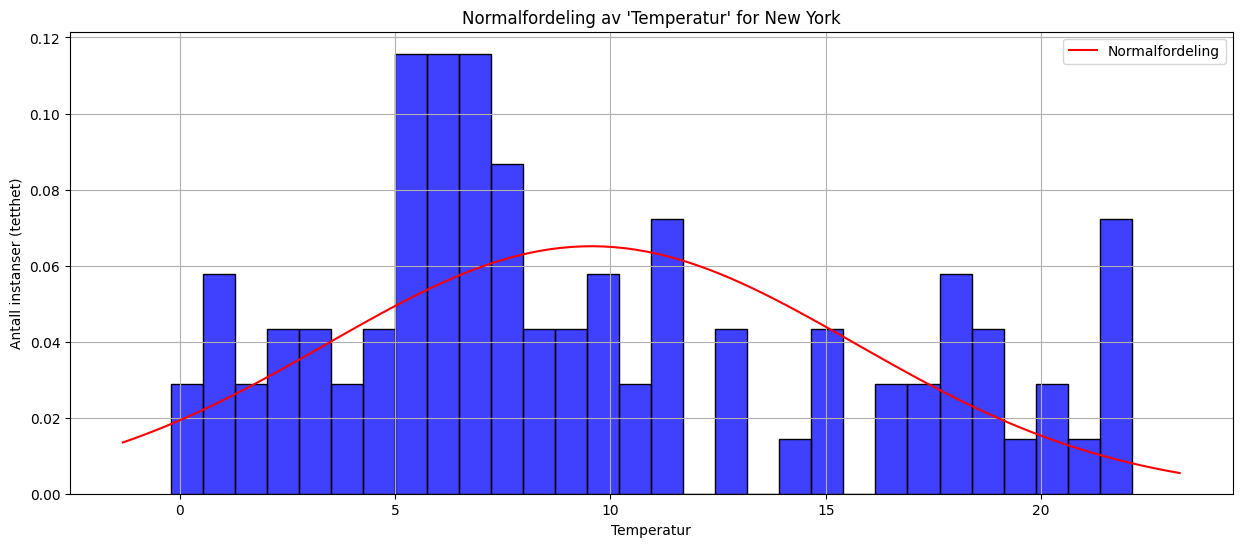

'Gjennomsnitt: 9.56, Median: 7.7, Standardavvik: 6.129'

In [15]:
def get_statistics(place, weather_entry):
    df = pd.DataFrame(get_weatherDataframe(place))

    #sjekker om entry er i datasettet
    if weather_entry not in df.columns:
        raise ValueError(f"{weather_entry} finnes ikke i datasettet.")


    #beregner ønskede verdier
    average = df[weather_entry].mean()  
    median = df[weather_entry].median()  
    std = df[weather_entry].std() 
    string = f"Gjennomsnitt: {round(average, 3)}, Median: {round(median, 3)}, Standardavvik: {round(std, 3)}"


    #plotter histogram og normalfordeling
    plt.figure(figsize=(15,6))
    sns.histplot(df[weather_entry], color='b', stat="density", bins=30)

    xmin, xmax = plt.xlim()  
    x = np.linspace(xmin, xmax, 100) #baserer diagrammet på største og minste verdi i datasettet
    p = norm.pdf(x, average, std) 
    plt.plot(x, p, 'r', label="Normalfordeling")
    plt.xlabel(weather_entry)
    plt.ylabel("Antall instanser (tetthet)")
    plt.title(f"Normalfordeling av '{weather_entry}' for {place}")
    plt.grid()
    plt.legend()
    plt.show() 

    return string


#get_statistics(locations["New York"][0], locations["New York"][1], "temp") #(feilmelding)
get_statistics("New York", value_weather_entry[0])


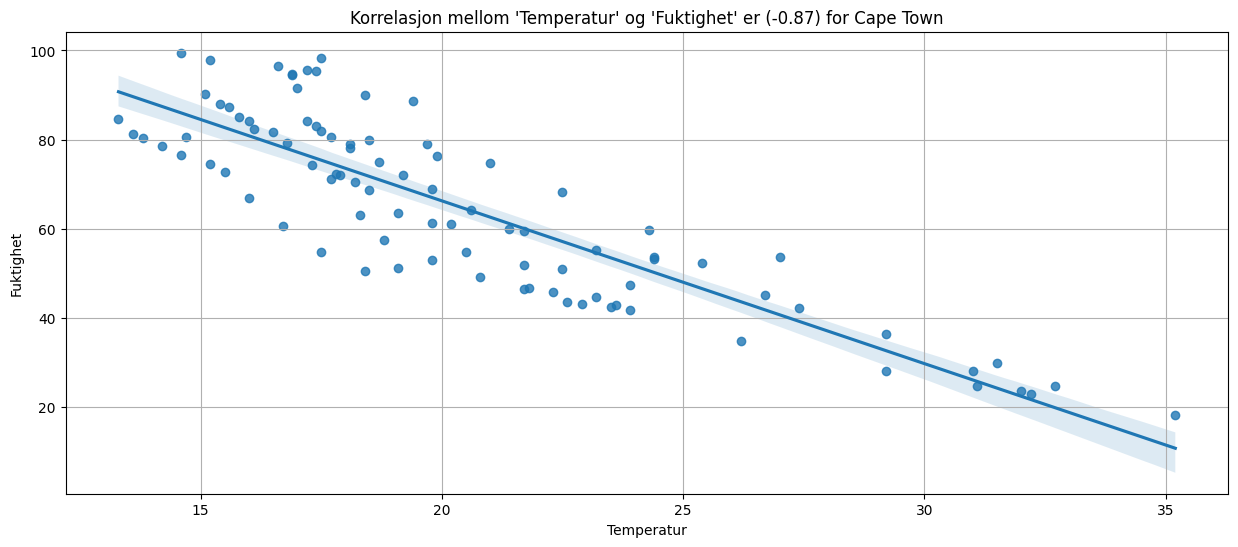

Korrelasjon mellom 'Temperatur' og 'Fuktighet' er (-0.87) for Cape Town


In [16]:
def correlation(place, weather_entry1, weather_entry2):
    df = get_weatherDataframe(place)


    #sjekker om entry er en instans i filen
    if weather_entry1 not in df.columns or weather_entry2 not in df.columns:
        raise Exception("Instans(ene) finnes ikke i datasettet")
    

    #regner ut korrelasjon
    correlation = df[weather_entry1].corr(df[weather_entry2])
    string = f"Korrelasjon mellom '{weather_entry1}' og '{weather_entry2}' er ({round(correlation,3)}) for {place}"


    plt.figure(figsize=(15,6))
    sns.regplot(x=df[weather_entry1], y=df[weather_entry2])
    plt.xlabel(weather_entry1)
    plt.ylabel(weather_entry2)
    plt.title(string)
    plt.grid(True)
    plt.show()

    return string


print(correlation("Cape Town", value_weather_entry[0], value_weather_entry[1]))


### Oppgave 5 - Visualisering

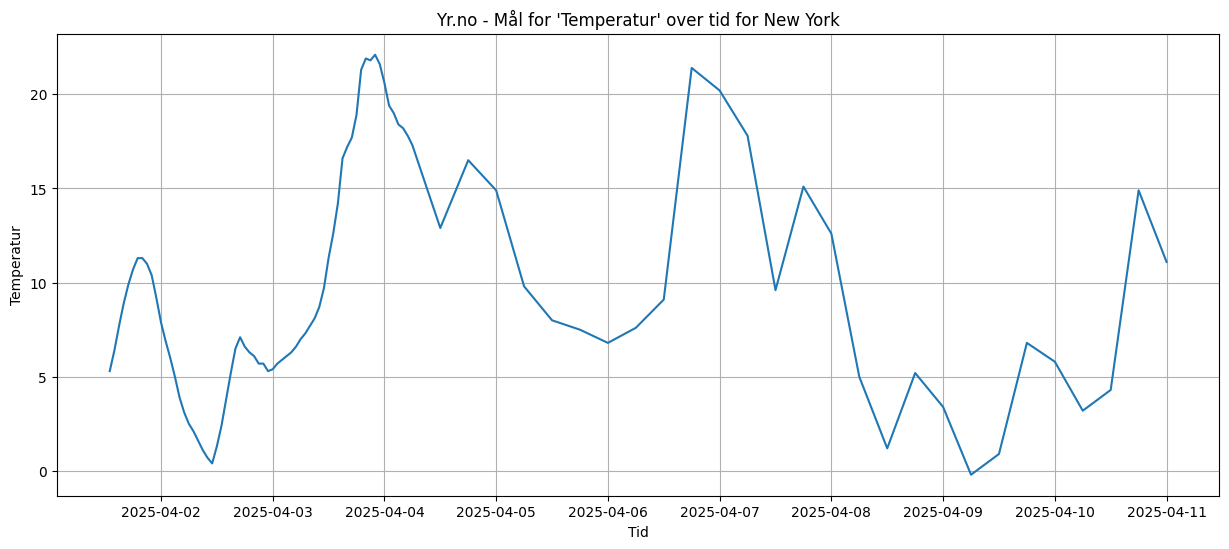

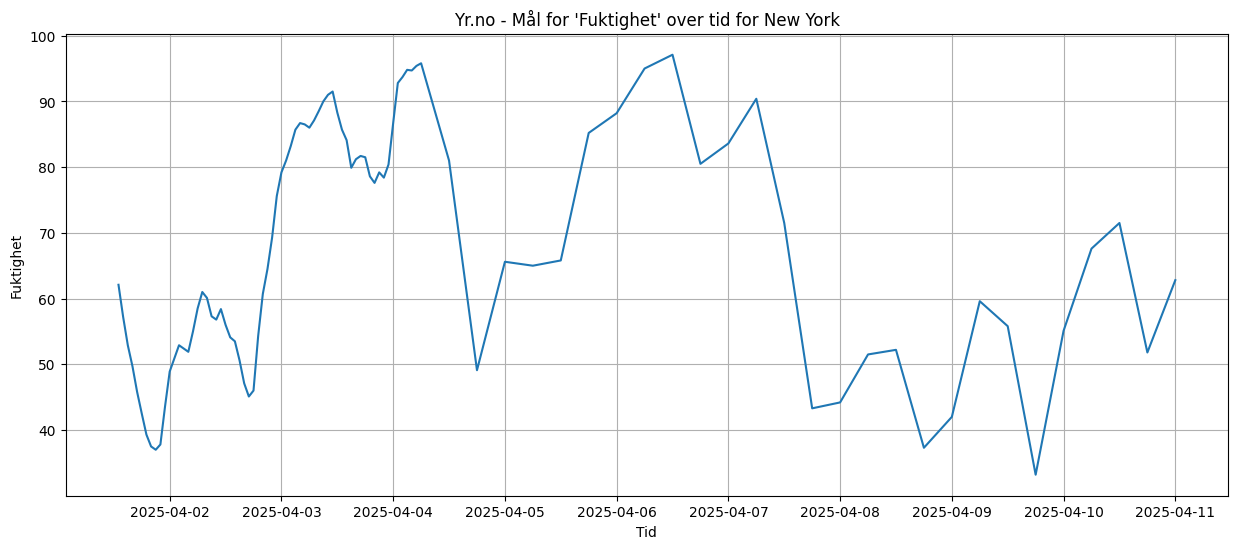

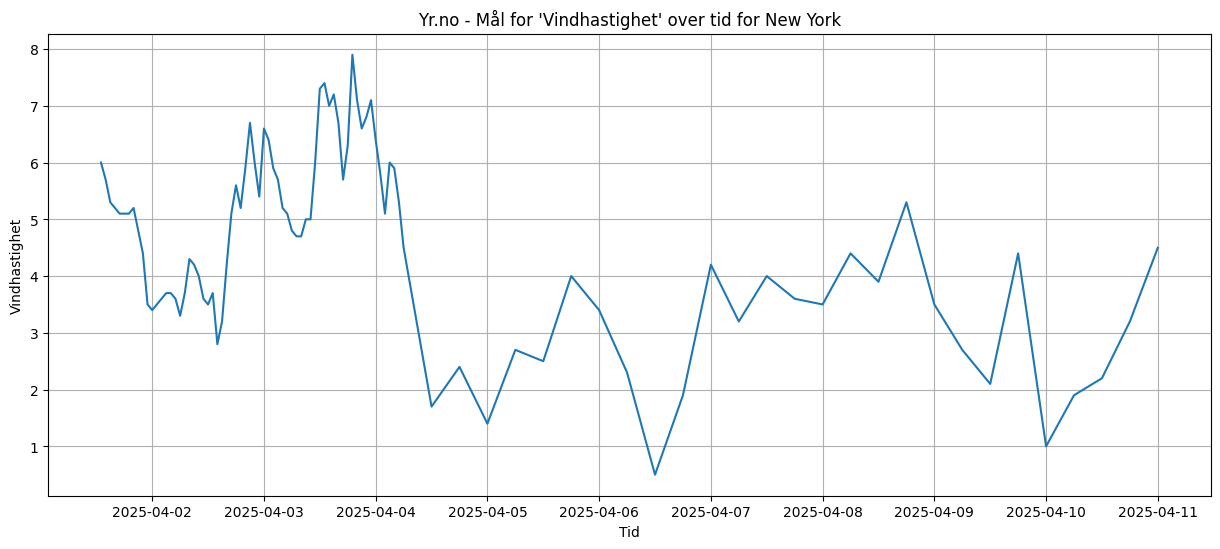

In [17]:
def plot_weather(place, weather_entry):
    df = get_weatherDataframe(place)

    #sjekker om entry er en instans i filen
    if weather_entry not in df.columns:
        raise Exception("Instans(ene) finnes ikke i datasettet")

    #lager grafen
    plt.figure(figsize=(15, 6))   
    sns.lineplot(data=df, x="Tid", y=weather_entry) 
    plt.xlabel("Tid")
    plt.ylabel(weather_entry)
    plt.title(f"Yr.no - Mål for '{weather_entry}' over tid for {place}")
    plt.grid(True)
    plt.show()


plot_weather("New York", value_weather_entry[0])
plot_weather("New York", value_weather_entry[1])
plot_weather("New York", value_weather_entry[2])



In [18]:
#mangler 5.4

### Oppgave 6 - Predikativ analyse